In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

import torch
import sys
sys.path.append('../')
# densenet 2d
from monai.networks.nets import DenseNet121
from monai.visualize import GradCAM
from networks.ATM_V9 import get_Unet_ATM_V9
from utils.file_utils import load_json
from utils.helper import show_img

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

In [2]:
# 展示cam
def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.
    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :returns: The default image with the cam overlay.
    """

    if np.max(img) > 1:
        print("The input image should np.float32 in the range [0, 1] \n Apply max-min to normalize to range [0, 1]")
        img = (img - img.min()) / (img.max() - img.min())
    
    if len(img.shape) == 2:
        img_arr = np.empty([256, 256, 3])
        img_arr[...] = np.expand_dims(img, axis=-1).astype(np.float32)

    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    cam = heatmap + img_arr
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

use deep supervision: False


/home/zfx/miniconda3/envs/zfx/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


The input image should np.float32 in the range [0, 1] 
 Apply max-min to normalize to range [0, 1]


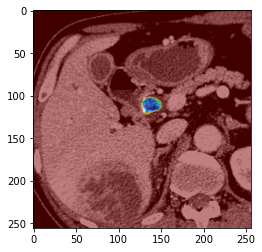

In [7]:
# 加载数据
data_json = '/data1/zfx/data/BileDuct/preprocessed_data/preprocess_dataset.json'
dataset = load_json(data_json)
test_data = dataset['test'][2]['preprocess_npy']

data = np.load(test_data)
index = 59
image = data[0][index]
label = data[1][index]
input = image[3:6]
input = torch.from_numpy(input.astype(np.float32)).unsqueeze(0)
# show_img(image[4])
# show_img(label[4])

# 加载模型
model_path = '/data1/zfx/code/segBileDuct/model/BileDuct/ATM_V9_dice_consistency_dot_5_withBestModel.pt'
model = get_Unet_ATM_V9(img_size=256, dsv=False, sample_slices=3)
model.load_state_dict(torch.load(model_path, map_location='cuda:0'))

# 模型预测
# model.eval()
# pre = model(input)
# output = pre
# show_img(output.squeeze().detach().numpy())


# 计算和展示GradCAM
cam = GradCAM(nn_module=model, target_layers='final')
result = cam(x=input)
heatmap = result[0][0]
vis = show_cam_on_image(image[1], mask=heatmap, use_rgb=True)
plt.imshow(vis)
plt.show()


The input image should np.float32 in the range [0, 1] 
 Apply max-min to normalize to range [0, 1]


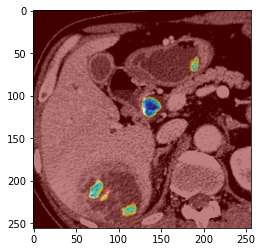

In [9]:
# 加载数据
data_json = '/data1/zfx/data/BileDuct/preprocessed_data/preprocess_dataset.json'
dataset = load_json(data_json)
test_data = dataset['test'][2]['preprocess_npy']

data = np.load(test_data)
index = 59
image = data[0][index]
label = data[1][index]
input = image[3:6]
input = torch.from_numpy(input.astype(np.float32)).unsqueeze(0)
# show_img(image[4])
# show_img(label[4])

# 加载模型
from networks.Unet import Unet
model_path = '/data1/zfx/code/segBileDuct/model/BileDuct/Unet_dice_withBestModel.pt'
model = Unet(3, 1)
model.load_state_dict(torch.load(model_path, map_location='cuda:0'))

# 模型预测
# model.eval()
# pre = model(input)
# output = pre
# show_img(output.squeeze().detach().numpy())


# 计算和展示GradCAM
cam = GradCAM(nn_module=model, target_layers='conv1_')
result = cam(x=input)
heatmap = result[0][0]
vis = show_cam_on_image(image[1], mask=heatmap, use_rgb=True)
plt.imshow(vis)
plt.show()
